# KNN

In [1]:
import pandas as pd
import numpy as np

In [3]:
from glob import glob

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
from tqdm import tqdm

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

In [ ]:
import shapely
import shapely.vectorized

from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

In [58]:
import json

In [75]:
np.random.seed(1)

## Extract Fingerprint Data for a Specific Floor

In [51]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "F5"

fingerprint_files = list(glob(f"../../data/wifi_fingerprint_manual/train/{site_id}/{floor_id}/*_wifi_fingerprint.csv"))

In [10]:
wifi_fingerprint_df_list = [pd.read_csv(file) for file in fingerprint_files]

In [11]:
wifi_fingerprint_df = wifi_fingerprint_df_list[0]

In [13]:
wifi_fingerprint_df.head()

,sys_ts,ssid,bssid,rssi,freq,last_seen_ts,x,y
0,1571902613823,dde9d466009093fb652c4f536d141a68de6ecdf9,10f4a9af21c48161c9f691a1f0e7f9d0f6f8e04d,-46,2412,1571902611960,164.117996,75.180115
1,1571902613823,da39a3ee5e6b4b0d3255bfef95601890afd80709,bb12b5d3c6fb1ddaffc55539c42a7924c0704289,-47,2412,1571902601397,164.117996,75.180115
2,1571902613823,da39a3ee5e6b4b0d3255bfef95601890afd80709,bb927914a94c58dfb79f3f06c77aecc6d07d0615,-50,2412,1571902611945,164.117996,75.180115
3,1571902613823,da39a3ee5e6b4b0d3255bfef95601890afd80709,802e6ec43411cbb2b258b4a7443076a563968c8e,-55,2412,1571902611981,164.117996,75.180115
4,1571902613823,dde9d466009093fb652c4f536d141a68de6ecdf9,cd3de7121fc7c7ffabb33634f90ebcedc3703956,-56,2412,1571902611980,164.117996,75.180115


In [20]:
def extract_bssid_set(wifi_fingerprint_df_list):
  bssid_set = set()

  for df in wifi_fingerprint_df_list:
    unique_bssid_list = df["bssid"].unique().tolist()
    bssid_set.update(unique_bssid_list)
  
  return bssid_set

In [21]:
def extract_ssid_set(wifi_fingerprint_df_list):
  ssid_set = set()

  for df in wifi_fingerprint_df_list:
    unique_ssid_list = df["ssid"].unique().tolist()
    ssid_set.update(unique_ssid_list)
  
  return ssid_set

In [22]:
bssid_set = extract_bssid_set(wifi_fingerprint_df_list)
ssid_set = extract_ssid_set(wifi_fingerprint_df_list)

In [23]:
print(f"The number of unique BSSIDs: {len(bssid_set)}")
print(f"The number of unique SSIDs: {len(ssid_set)}")

The number of unique BSSIDs: 1306
The number of unique SSIDs: 269


In [26]:
bssid_vector = np.array(list(bssid_set))

In [31]:
def create_fingerprint_vector(group_data: pd.DataFrame, bssid_vector: np.ndarray, not_seen_rssi: float = -1000) -> np.ndarray:
  v = np.zeros_like(bssid_vector, dtype=np.float32) + not_seen_rssi

  for bssid, rssi in group_data[["bssid", "rssi"]].values:
    v[bssid_vector == bssid] = rssi

  return v

In [45]:
fingerprint_tuples = []

for df in tqdm(wifi_fingerprint_df_list):
  for (sys_ts, x, y), group_data in df.groupby(["sys_ts", "x", "y"]):
    fingerprint_vector = create_fingerprint_vector(group_data, bssid_vector, not_seen_rssi=-1000)
    fingerprint_tuples.append((x, y, fingerprint_vector))

100%|██████████| 133/133 [00:07<00:00, 18.16it/s]


In [46]:
len(fingerprint_tuples)

2891

In [49]:
fingerprint_df = pd.DataFrame(fingerprint_tuples, columns=["x", "y", "v"])

## Extracting Floormap Data

In [53]:
def parse_polygon_coordinates(geojson_feature):
  polygons = []

  feature_type = geojson_feature["geometry"]["type"]

  if feature_type == "MultiPolygon":
    for coord_set in geojson_feature["geometry"]["coordinates"]:
        polygons.append(np.array(coord_set[0], dtype=np.float64))

  elif feature_type == "Polygon":
    polygons.append(
        np.array(geojson_feature["geometry"]["coordinates"][0], dtype=np.float64)
    )

  return polygons

In [54]:
def find_bound(floor_coordinates):
  assert len(floor_coordinates) > 0

  x_min, y_min = np.min(floor_coordinates[0], axis=0)
  x_max, y_max = np.max(floor_coordinates[0], axis=0)

  for coords in floor_coordinates[1:]:
    _x_min, _y_min = np.min(coords, axis=0)
    _x_max, _y_max = np.max(coords, axis=0)
    x_min = np.min([x_min, _x_min])
    y_min = np.min([y_min, _y_min])
    x_max = np.max([x_max, _x_max])
    y_max = np.max([y_max, _y_max])

  return x_min, y_min, x_max, y_max

In [55]:
def scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=False):
  if not inplace:
    coords = coords.copy()

  coords[:, 0] = (coords[:, 0] - x_min) / (x_max - x_min) * width_meter
  coords[:, 1] = (coords[:, 1] - y_min) / (y_max - y_min) * height_meter

  return coords

In [56]:
def extract_floor_map_geometries(floor_map, floor_info, transform=None):
  if transform is None:
    transform = transform_identity()

  # Finding the bound of the floormap
  floor_coordinates = parse_polygon_coordinates(floor_map["features"][0])
  x_min, y_min, x_max, y_max = find_bound(floor_coordinates)

  width_meter = floor_info["map_info"]["width"]
  height_meter = floor_info["map_info"]["height"]

  # Scaling floormap
  for coords in floor_coordinates:
    scale(coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True)
    coords[:] = transform(coords)

  # Extract store polygons
  store_coordinates = []

  for geojson_feature in floor_map["features"][1:]:
    polygons = parse_polygon_coordinates(geojson_feature)
    # In-place normalization
    for coords in polygons:
      scale(
          coords,
          x_min,
          y_min,
          x_max,
          y_max,
          width_meter,
          height_meter,
          inplace=True,
      )
      coords[:] = transform(coords)
      store_coordinates.append(coords)

  # Scaling transformed coordinates
  x_min, y_min, x_max, y_max = find_bound(floor_coordinates)

  for coords in floor_coordinates:
    scale(
        coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True
    )

  for coords in store_coordinates:
    scale(
        coords, x_min, y_min, x_max, y_max, width_meter, height_meter, inplace=True
    )

  floor_polygons = [Polygon(coords) for coords in floor_coordinates]
  store_polygons = [Polygon(coords) for coords in store_coordinates]

  return (
    floor_polygons,
    store_polygons,
    x_min,
    y_min,
    x_max,
    y_max,
    width_meter,
    height_meter,
  )

In [59]:
floor_info_filename = f"../../data/metadata/{site_id}/{floor_id}/floor_info.json"
floor_map_filename = f"../../data/metadata/{site_id}/{floor_id}/geojson_map.json"

with open(floor_info_filename) as f:
  floor_info = json.load(f)

with open(floor_map_filename) as f:
  floor_map = json.load(f)

In [62]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

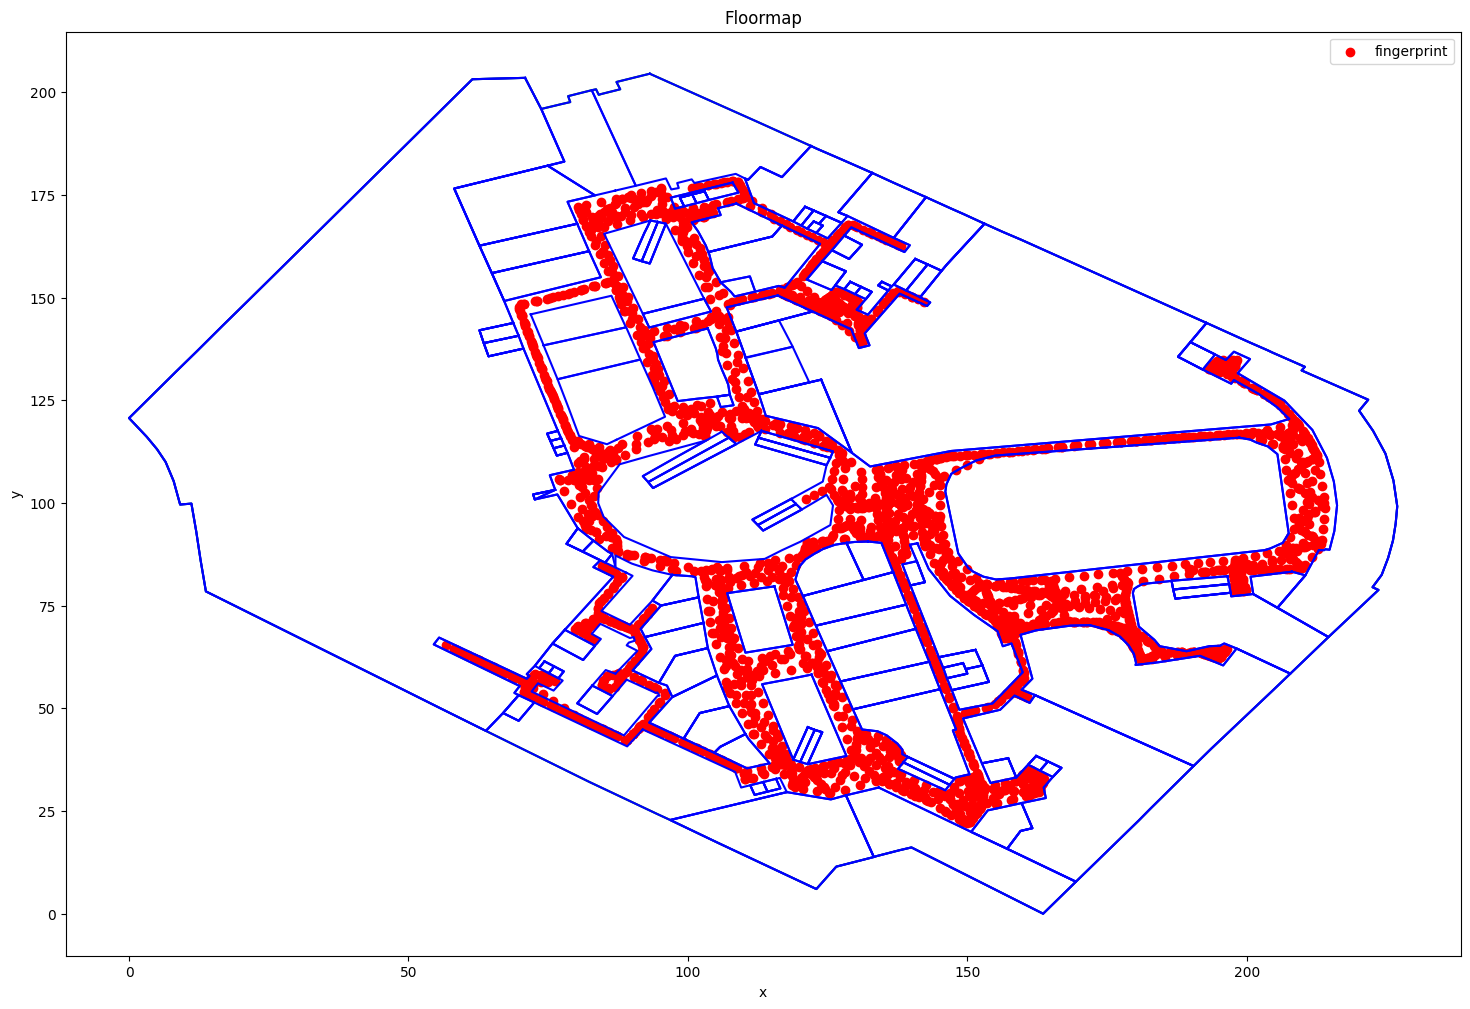

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
fingerprint_location = transform_func(fingerprint_df[["x", "y"]].values)
ax.scatter(fingerprint_location[:, 0], fingerprint_location[:, 1], marker="o", color="red", label="fingerprint")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## KNN Regression

In [76]:
X = np.vstack(fingerprint_df["v"].values)
y = fingerprint_df[["x", "y"]].values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [84]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

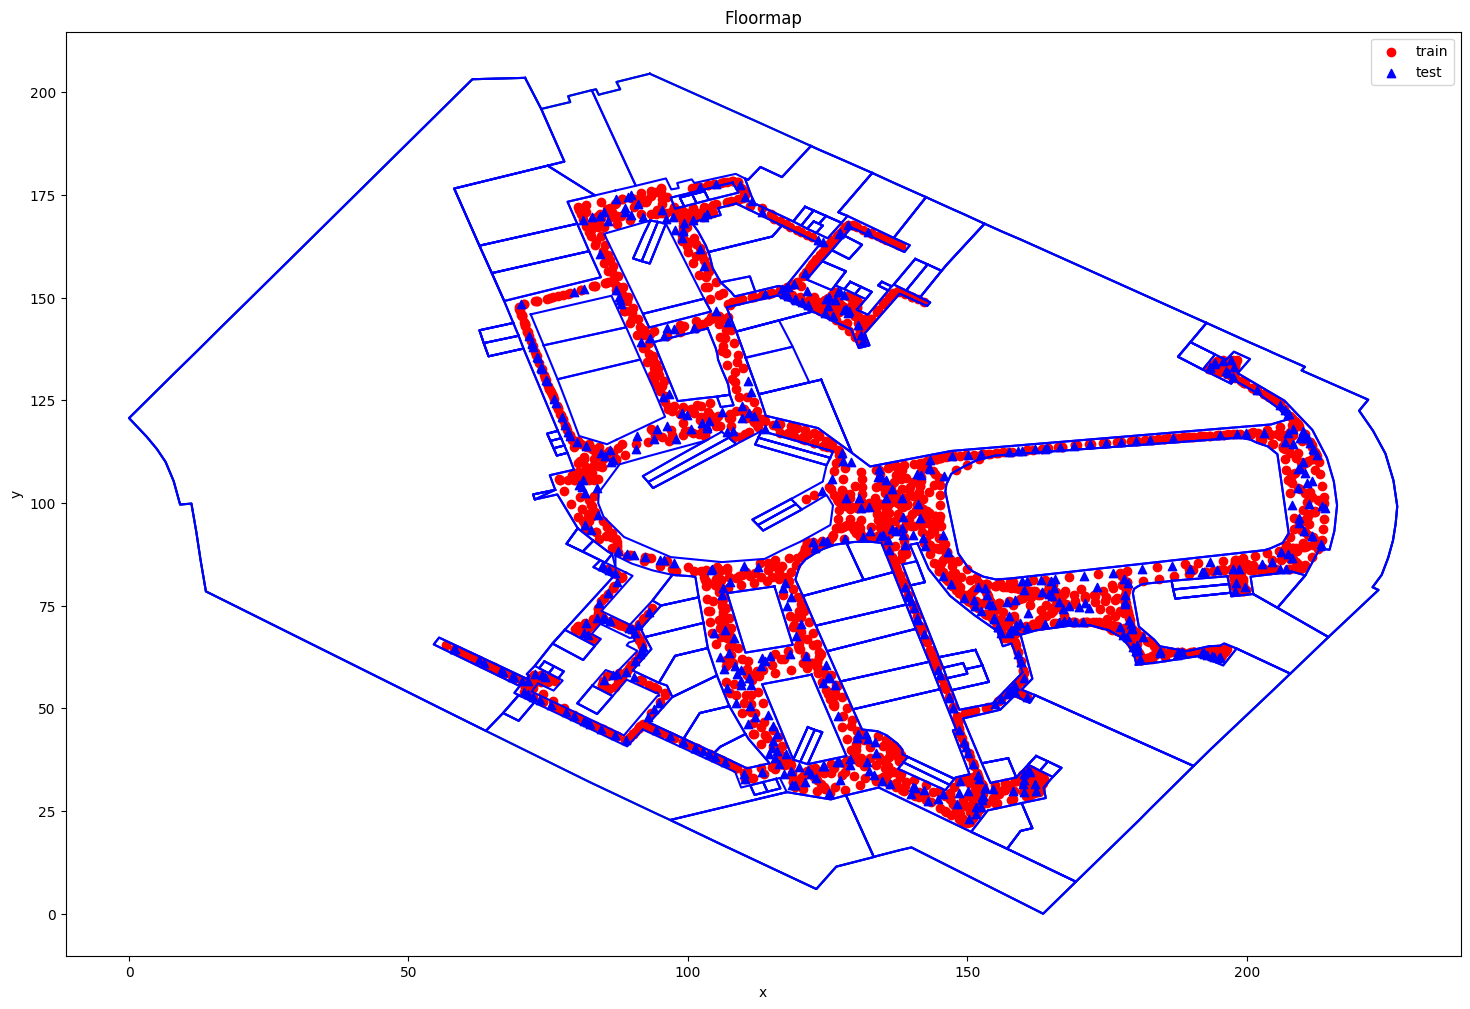

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
    x, y = floor_polygon.exterior.xy
    ax.plot(x, y, color="green")

for store_polygon in store_polygons:
    x, y = store_polygon.exterior.xy
    ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

# Adding ground-truth location
fingerprint_location = transform_func(fingerprint_df[["x", "y"]].values)
ax.scatter(y_train[:, 0], y_train[:, 1], marker="o", color="red", label="train")
ax.scatter(y_test[:, 0], y_test[:, 1], marker="^", color="blue", label="test")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [146]:
k_values = list(range(1, 11))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

In [ ]:
std_errors

0 2.2309849961213937 1.2575536104742224
1 1.785467277515681 1.774078022610896
2 2.21441249032418 1.6932951558191494
3 2.469956453306176 1.9973000868243955
4 2.788996145246937 2.143167740374033
5 3.0888766629455042 2.3806505165381657
6 3.396783880018566 2.5992342400537796
7 3.6639059492650246 2.724407076235943
8 3.9725322184419105 3.0280627046423447
9 4.248531418304143 3.244497125105404


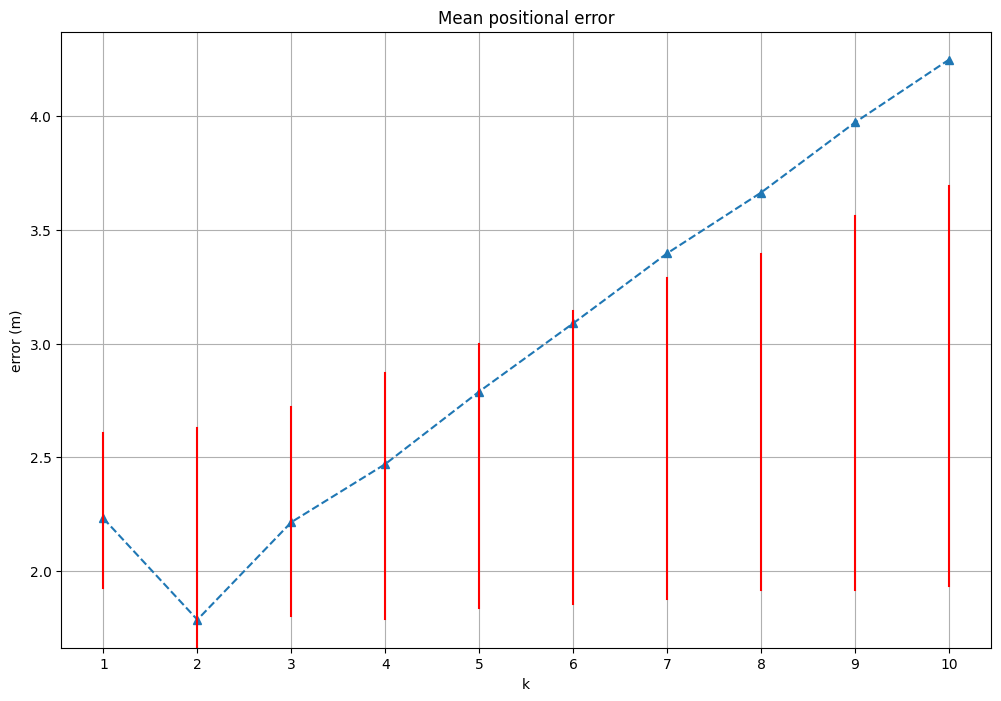

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

mean_errors = [errors.mean() for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.plot(k_values, mean_errors, marker="^", ls="--")
for i, (mean_error, std_error) in enumerate(zip(mean_errors, std_errors)):
  # TODO: Incorrect -> fix
  ax.axvline(x=k_values[i], color="red", ymin=(mean_error-std_error), ymax=(mean_error+std_error))

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean positional error")

ax.grid()

plt.show()

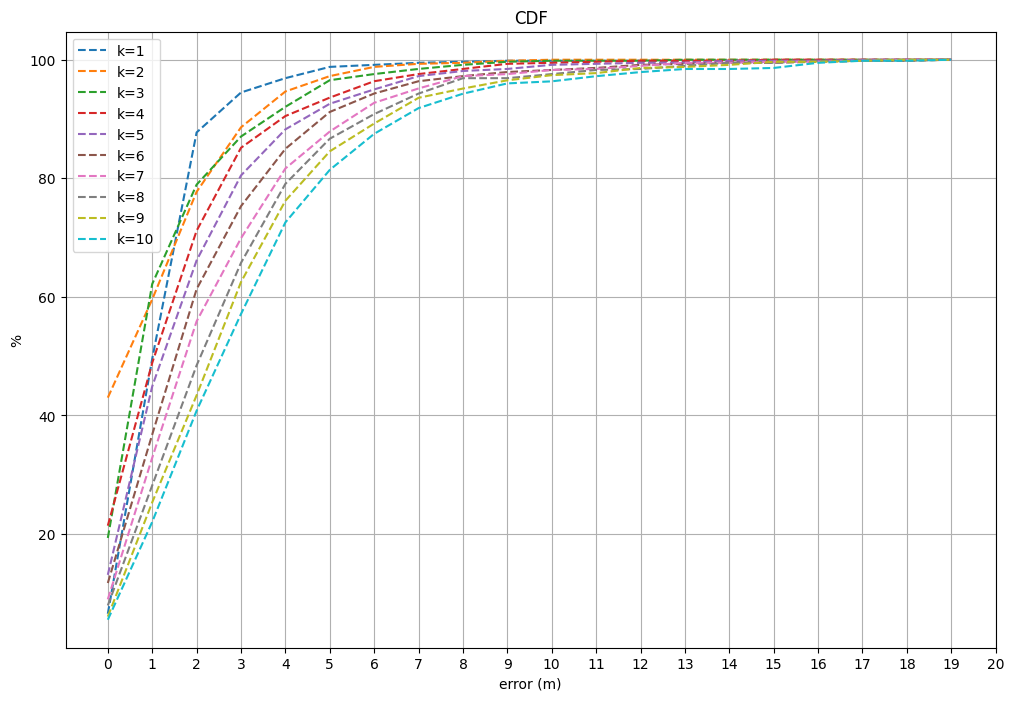

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for k, errors in zip(k_values, error_list):
  pdf, bins = np.histogram(errors, bins=20, range=(0, 20), density=True)
  error_cdf = np.cumsum(pdf)
  ax.plot(bins[:-1], error_cdf * 100, ls="--", label="k={}".format(k))

ax.set_xlabel("error (m)")
ax.set_ylabel("%")
ax.set_xticks(bins)
ax.set_title("CDF")

ax.grid()
ax.legend()

plt.show()